In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees, pearson
from scipy.stats import skew, entropy, gaussian_kde, kurtosis
import pandas as pd
import seaborn
import json
import pyprind

In [3]:
studies = json.load( open( 'data/studies.json' ) )

def load_study( study ) :
    T1  = SuchTree( study['host'] )
    T2  = SuchTree( study['guest'] )
    links = pd.DataFrame.from_csv( study['links'] )
    links = links.loc[ T1.leafs.keys() ]
    links = links[ T2.leafs.keys() ]
    return SuchLinkedTrees( T1, T2, links )

In [12]:
p = pyprind.ProgBar( len(studies), title='building graph Laplacian spectra...' )

bandwidth = 0.2

spectra = []
for study in studies :
    SLT = load_study( study )
    eg = SLT.spectrum()
    spectra.append( gaussian_kde( eg / max(eg), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) ) )
    p.update()

building graph Laplacian spectra...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:09


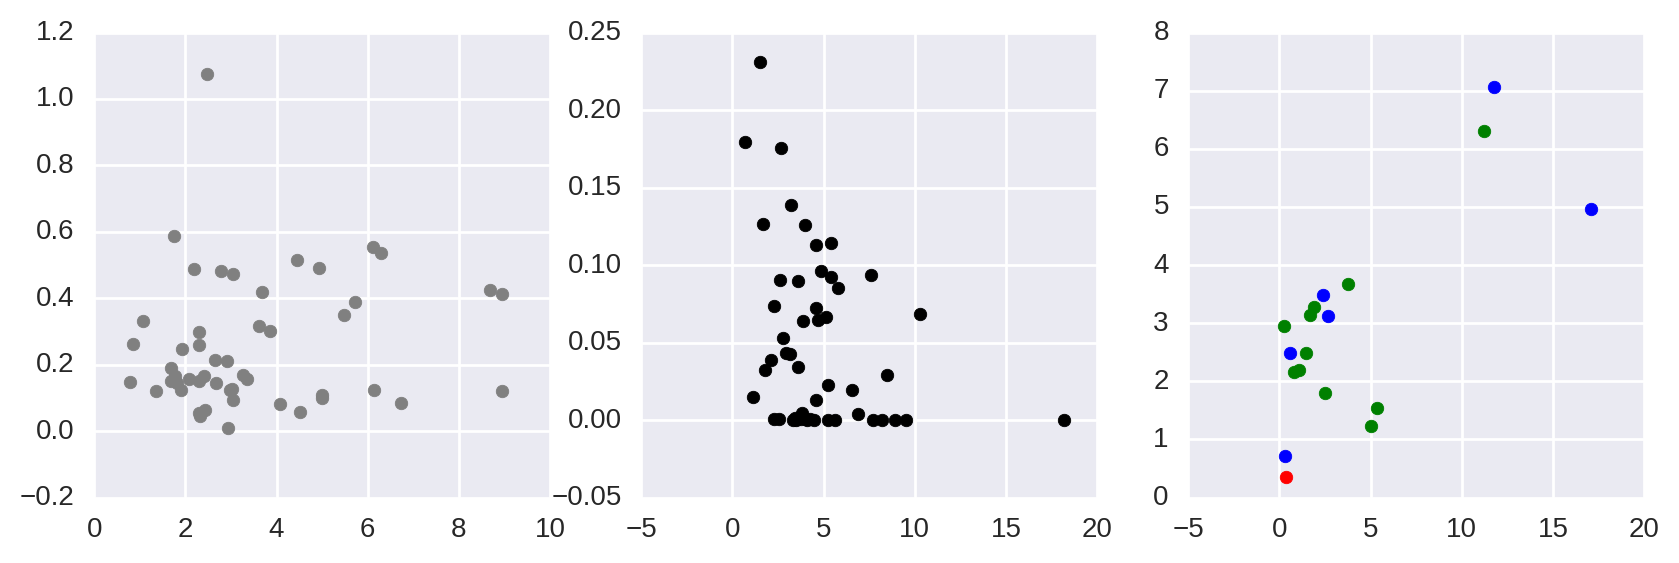

In [13]:
figure(figsize=(10,3))

typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'green',
              'pollination' : 'blue' }

for i,g in enumerate([ ['null'], ['perfect'], ['parasitism', 'frugivory', 'pollination' ] ]) :
    subplot(1,3,i+1)
    for study,eg,s in zip( studies, egs, spectra ) :
        if not study['type'] in g : continue
        #plot( s, color=typecolor[study['type']], lw=0.5 )
        scatter(  kurtosis( s ), eg[-1]-eg[-2], color=typecolor[study['type']]  )

In [15]:
def pdd( a, b ) :
    return ( 0.5 * entropy( a, b ) + 0.5 * entropy( b, a ) )**(0.5)

distances = zeros( ( len(spectra), len(spectra) ) )

for i,I in enumerate(spectra) :
    for j,J in enumerate(spectra) :
        if i == j : continue
        distances[i,j] = e**pdd( I, J )

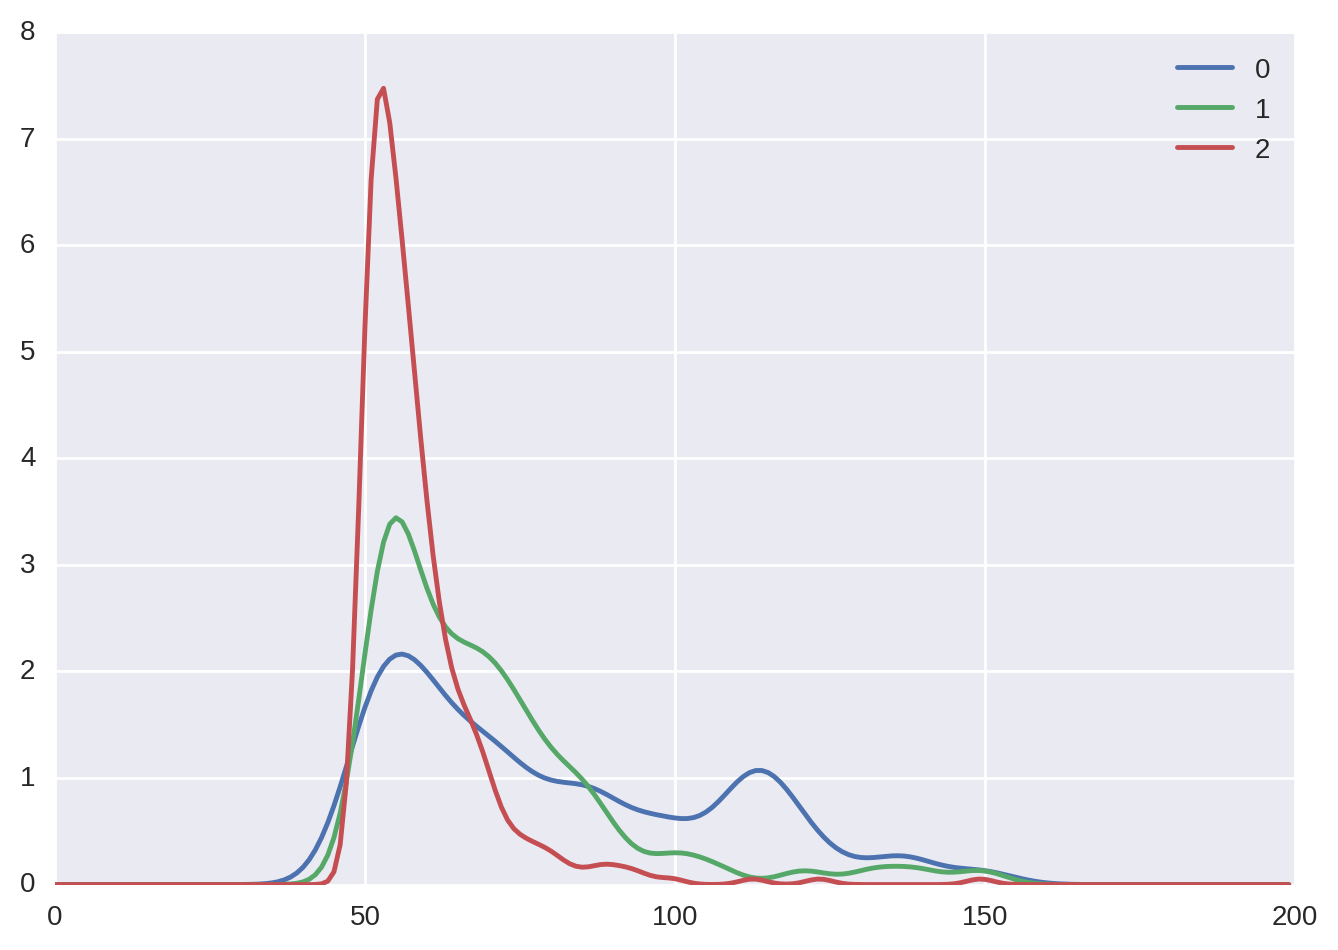

In [16]:
plot( spectra[0], label=0 )
plot( spectra[1], label=1 )
plot( spectra[2], label=2 )
legend()

In [17]:
pdd( spectra[0], spectra[2] )

1.0512707099046315

/home/russell/opt/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/russell/opt/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


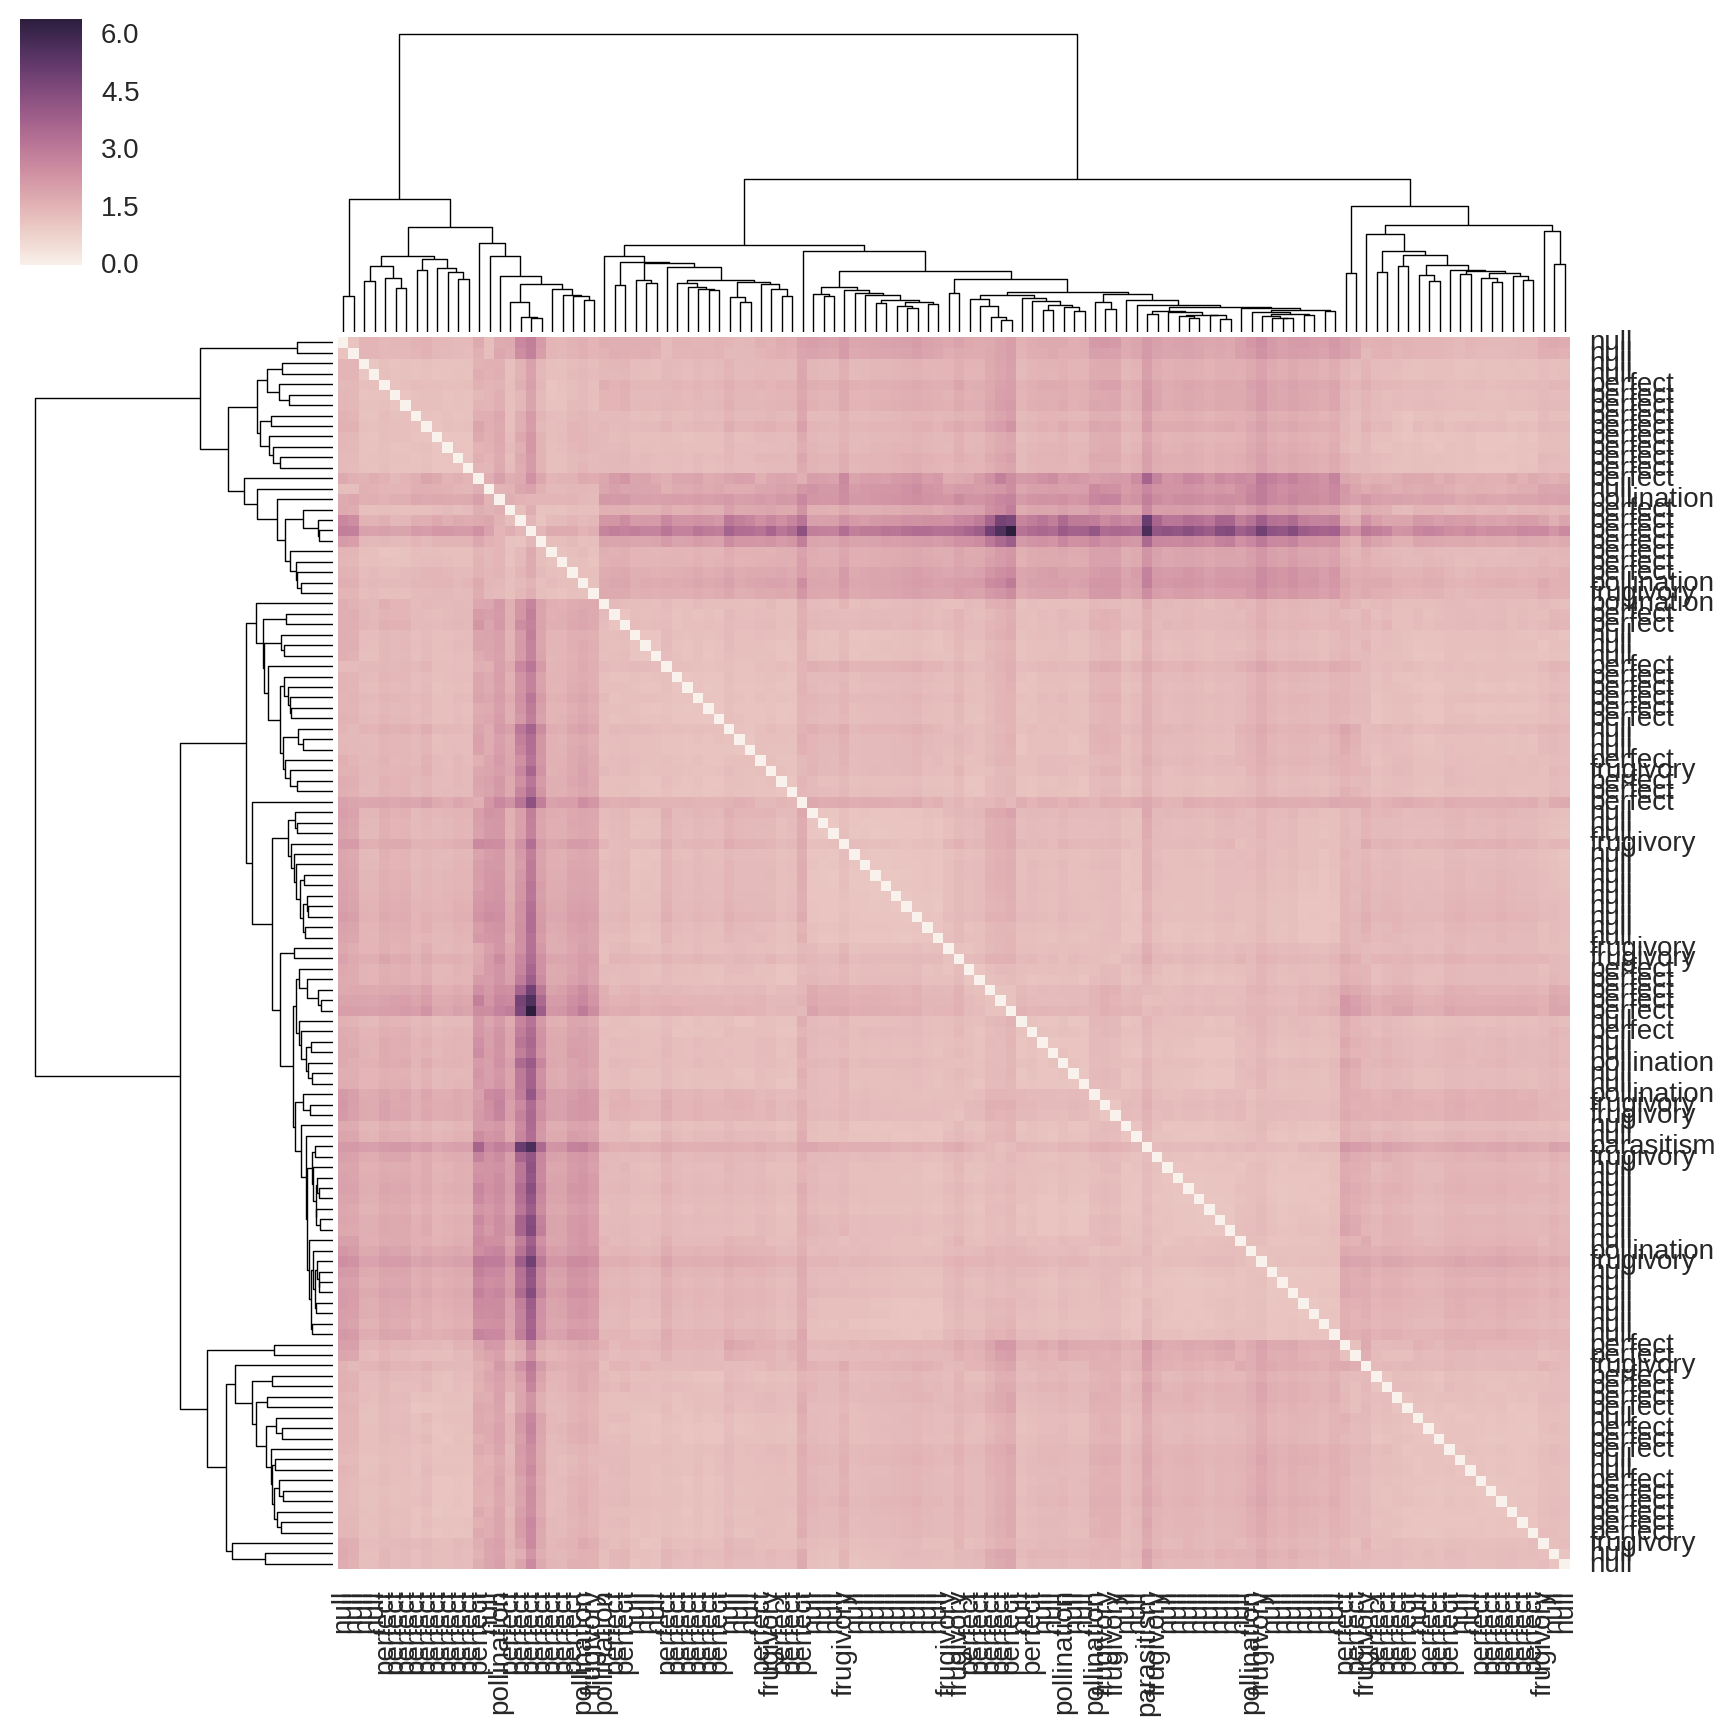

In [18]:
studytypes = map( lambda x : x['type'], studies )
cm = seaborn.clustermap( distances, xticklabels=studytypes, yticklabels=studytypes, metric="correlation" )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [19]:
N = 100
M = 5
p = pyprind.ProgBar( N*M, title='calculating spectral distances...' )

SLT = load_study( studies[1] )

a = real( eigvals( SLT.laplacian() ) )
A = gaussian_kde( a / max(a), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )

s,d = [],[]

for i in xrange( N ) :
    for j in xrange( M ) :
        b = real( eigvals( SLT.laplacian( swaps=i ) ) )
        B = gaussian_kde( b / max(b), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        s.append( i ) 
        d.append( e**pdd( A, B ) )
        p.update()

calculating spectral distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:05


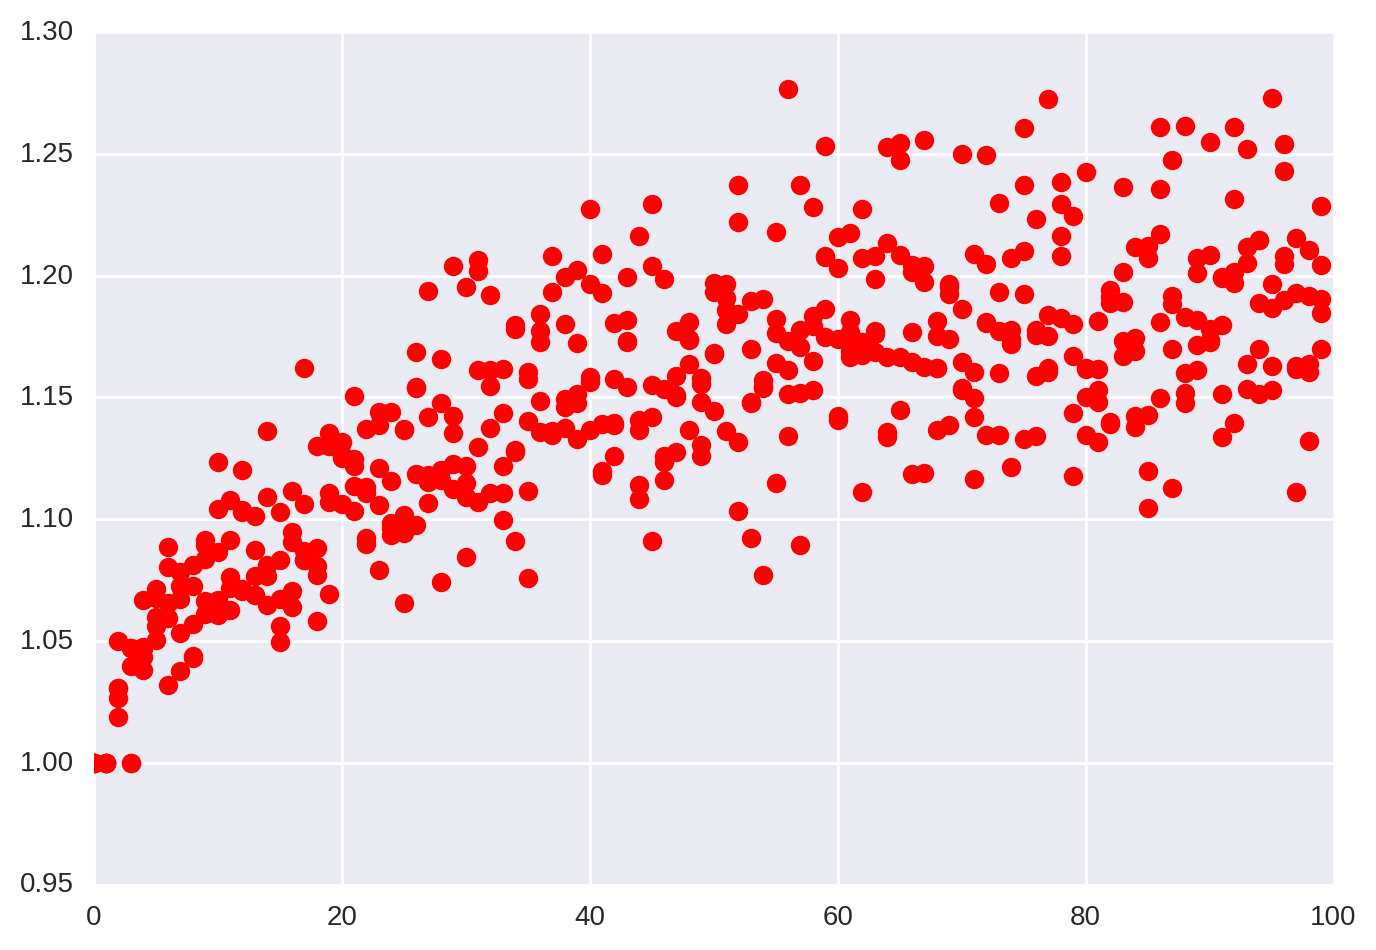

In [20]:
plot(s,d,'ro')

In [49]:
N = 3
M = 100

p = pyprind.ProgBar( N*M, title='calculating spectral distances...' )

SLTa = load_study( studies[0] )
SLTb = load_study( studies[6] )

d = []
s = []

for i in xrange( N ) :
    for j in xrange( M ) :
        a = real( eigvals( SLTa.laplacian( additions=i ) ) )
        A = gaussian_kde( a / max(a), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        b = real( eigvals( SLTb.laplacian( additions=i ) ) )
        B = gaussian_kde( b / max(b), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        s.append( i ) 
        d.append( pdd( A, B ) )
        p.update()

calculating spectral distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:02


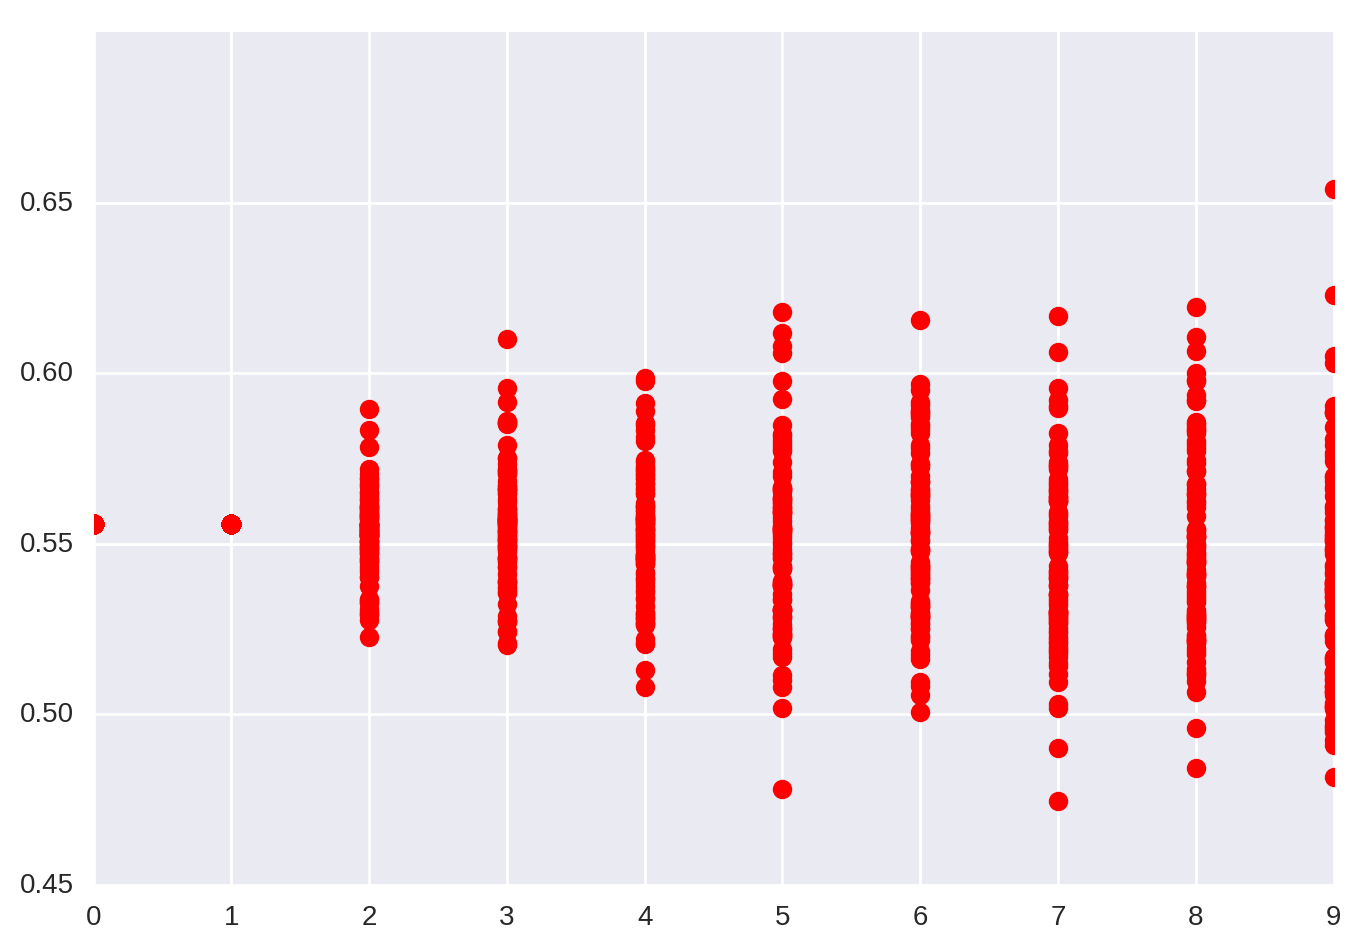

In [32]:
plot(s,d,'ro')

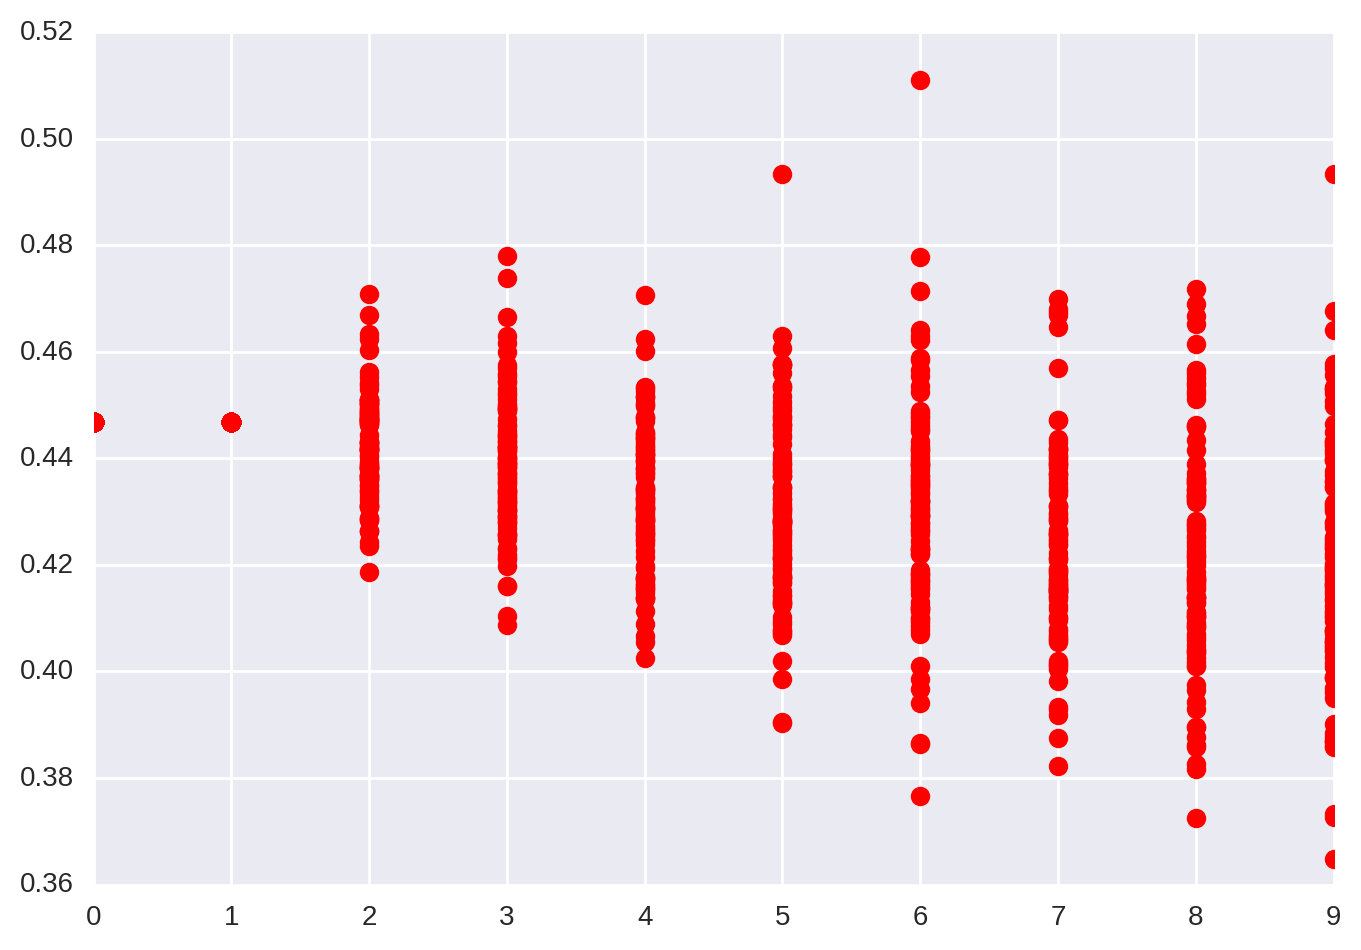

In [30]:
plot(s,d,'ro')

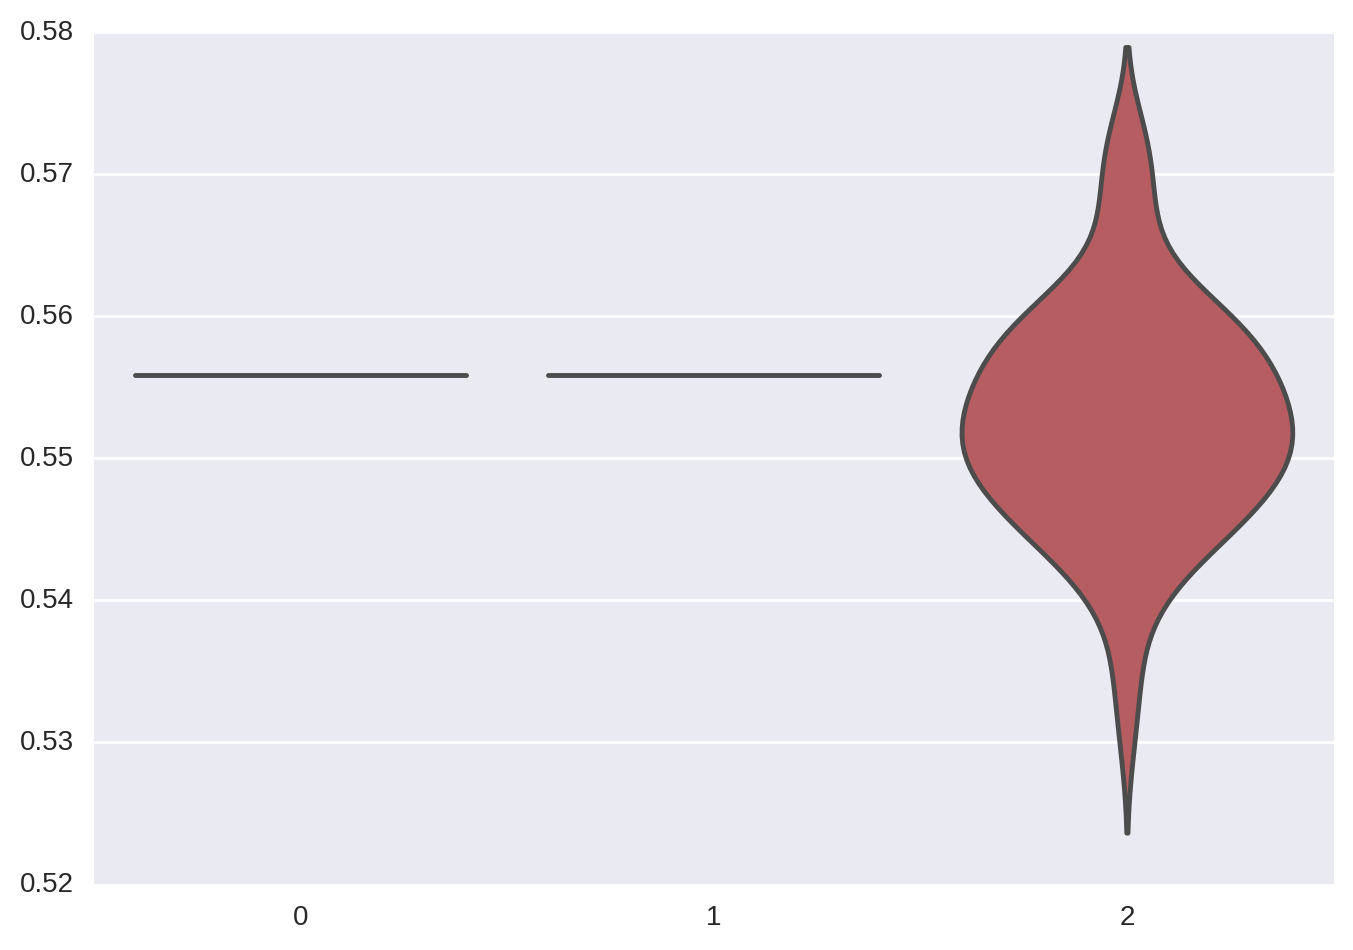

In [50]:
seaborn.violinplot(s,d,inner=None)
#seaborn.stripplot(s,d,jitter=True)

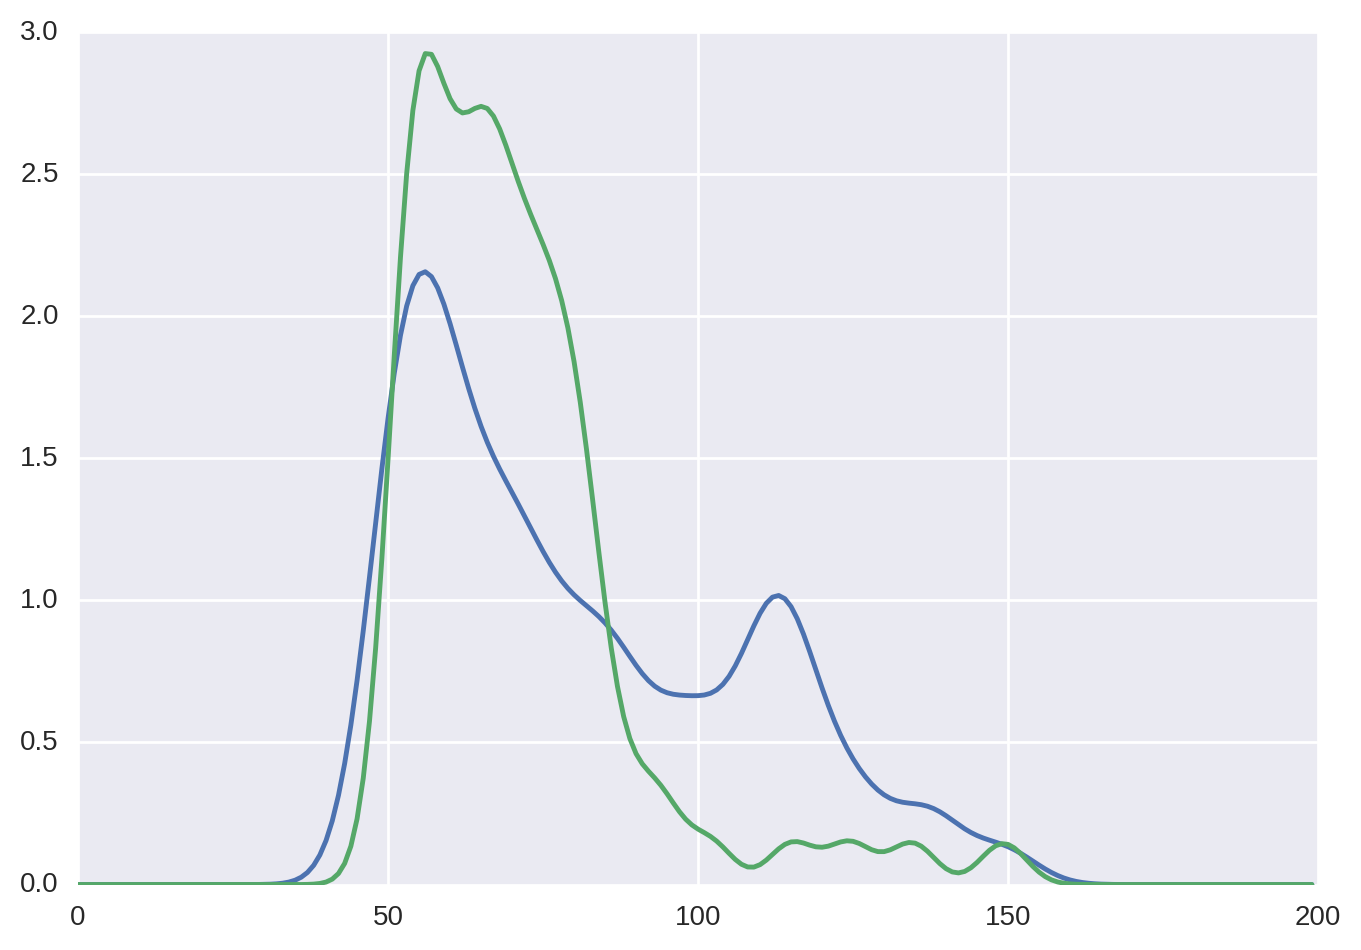

In [54]:
plot(A)
plot(B)

In [27]:
N = 10
M = 4

d = []
s = []

p = pyprind.ProgBar( len(studies), title='calculating permuted spectra...' )

permutations = []
for study in studies :
    ps = []
    for i in xrange( N ) :
        SLT = load_study( study )
        a = SLT.spectrum( swaps=M )
        A = gaussian_kde( a / max(a), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        ps.append( A )
    permutations.append( ps )
    p.update()

p = pyprind.ProgBar( len(studies)**2, title='calculating permuted distances...' )

distances = zeros( ( len(studies), len(studies) ) )
variances = zeros( ( len(studies), len(studies) ) )

for i,perm1 in enumerate( permutations ) :
    for j,perm2 in enumerate( permutations ) :
        d = []
        for spec1 in perm1 :
            for spec2 in perm2 :
                d.append( pdd( spec1, spec2 ) )
        distances[i,j] = mean( d )
        variances[i,j] = std( d )
        p.update()

names = [ s['name'] for s in studies ]        

D = pd.DataFrame( distances, columns=names, index=names )
V = pd.DataFrame( variances, columns=names, index=names )

calculating permuted spectra...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:41
calculating permuted distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:59


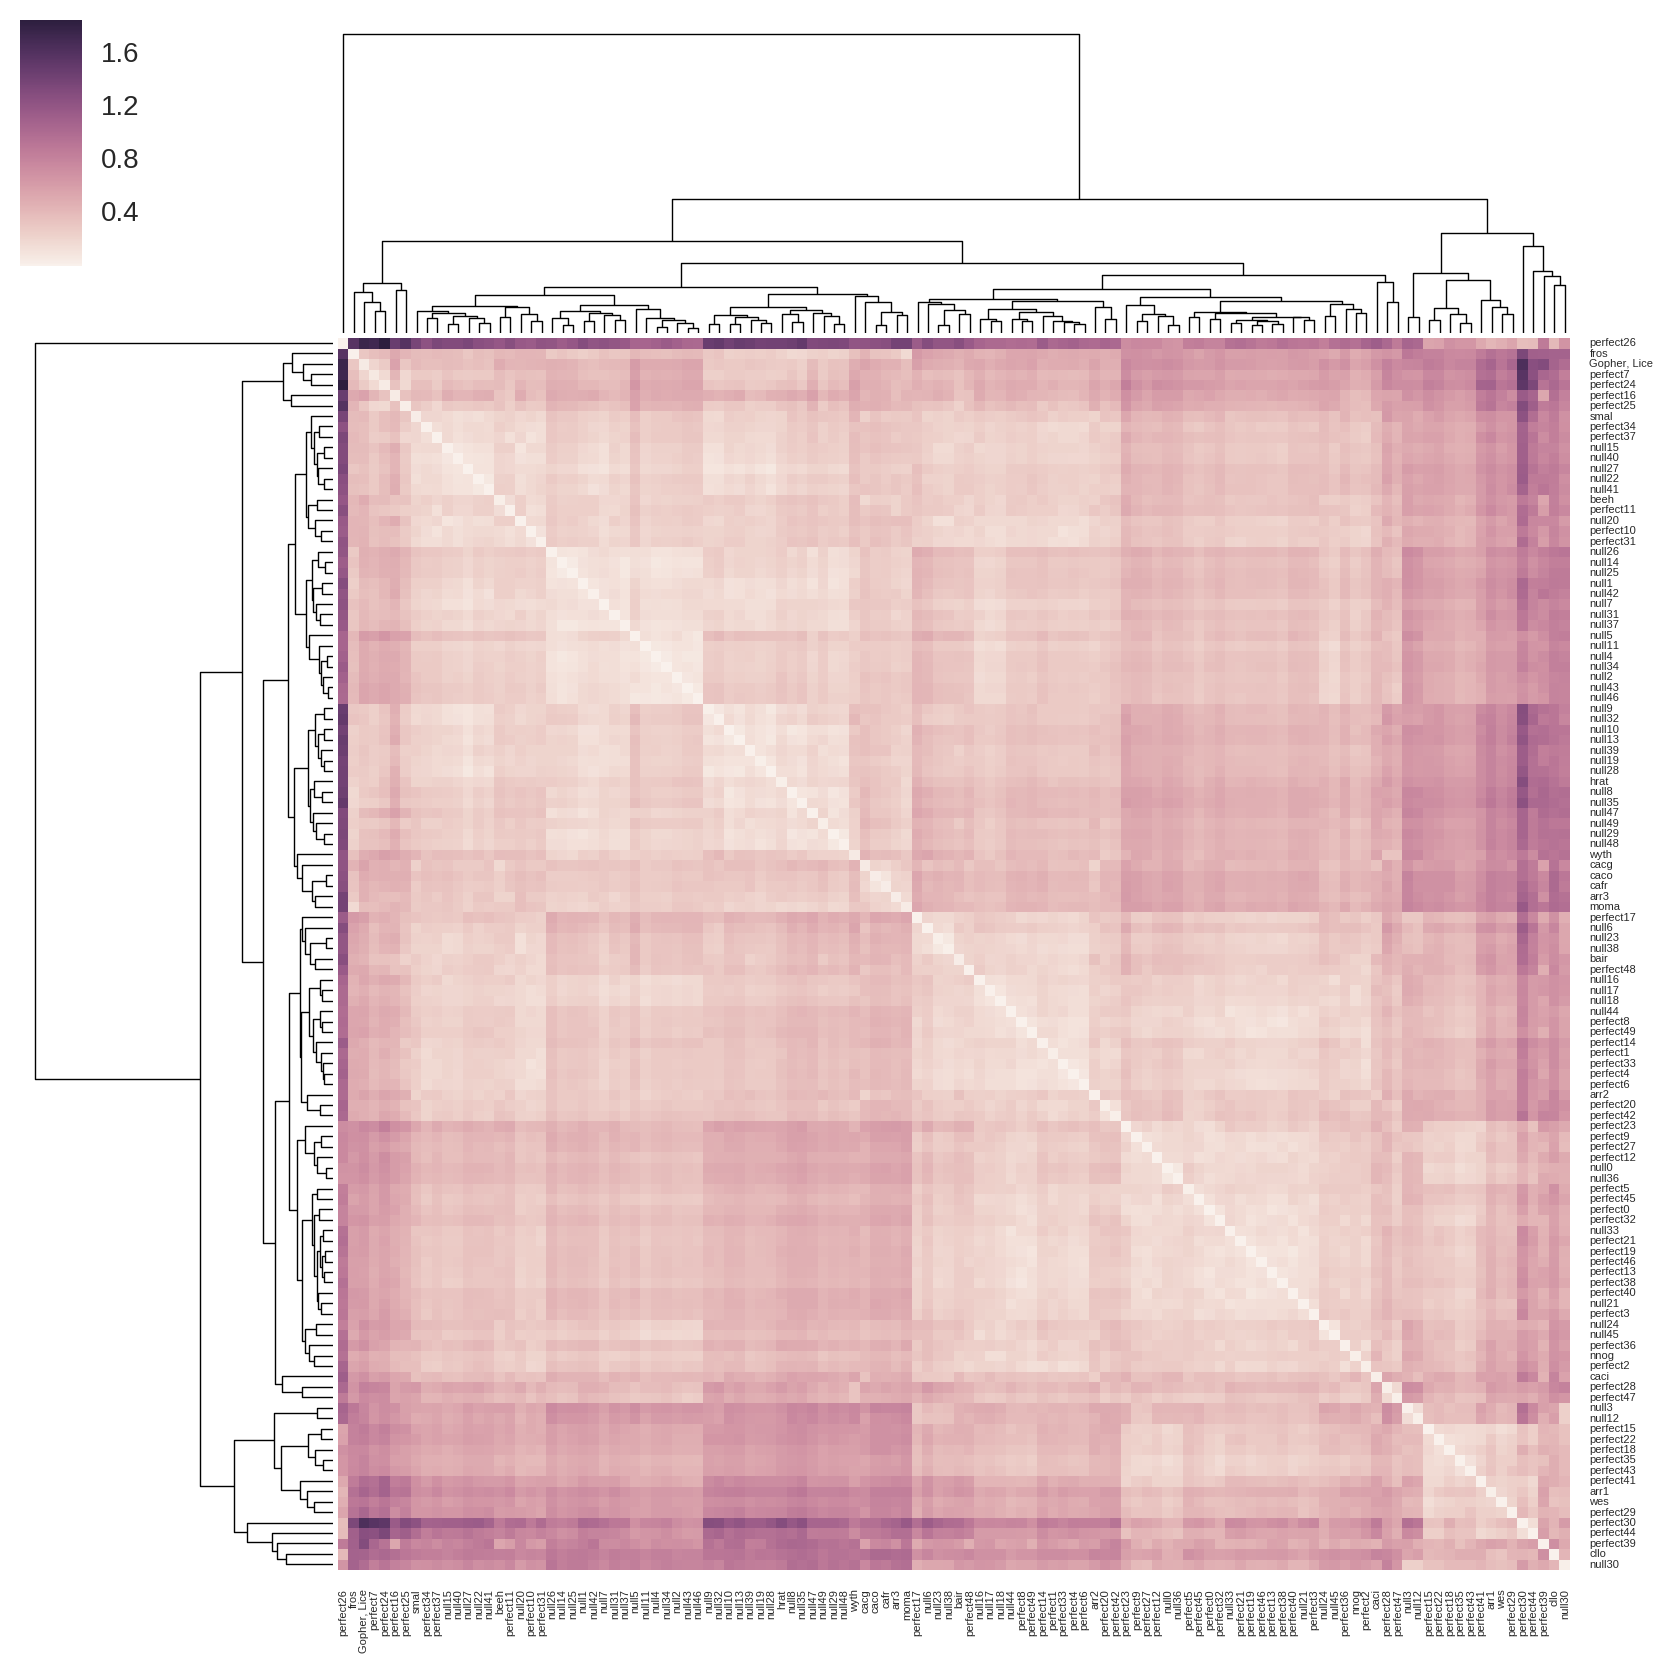

In [28]:
D = pd.DataFrame.from_csv( 'annealed_distances.csv' )
cm = seaborn.clustermap( D )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=4 )
ticks = setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=4 )